In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.9.2', '1.21.6')

In [18]:
#!unzip "/content/drive/MyDrive/CV_2023_SC_Dataset.zip"


In [19]:
#shutil.move("/content/personA/Train/personA_33.png","/content/personA/Test")
#shutil.move("/content/personA/Test/personA_30.png","/content/personA/Train")

In [20]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)
#cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)

def read_image(index):
    path = os.path.join(index[0],index[1])
    image = cv2.imread(path)
    try:
      image = cv2.resize(image, (128,128))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except:
      print(path)
      print("An exception occurred")
    return image

In [21]:
def create_triplets(labels,images_name,folder):
    triplets = []

    n=len(labels)
    index_first_real=0
    for i in range(n-1):
        if(labels[i]=="real"):
          index_first_real=i
          break
    for i in range(index_first_real,n):
            for j in range(i+1,n):
                anchor = (folder,images_name[i])
                positive = (folder,images_name[j])
                f=random.randint(0,index_first_real-1)
                negative = (folder,images_name[f])
                triplets.append((anchor, positive, negative))
    random.shuffle(triplets)
    return triplets

In [22]:
Folders=[chr(i) for i in range(ord("A"),ord("A")+5)]
print(Folders)
train_triplet=[]
test_triplet=[]
Persons={}
for Char in Folders:
  SigVerificationTrainLabels=pd.read_csv(f"/content/person{Char}/Train/person{Char}_SigVerificationTrainLabels.csv")
  SigVerificationTestLabels=pd.read_csv(f"/content/person{Char}/Test/person{Char}_SigVerificationTestLabels.csv")
#############################################################################
  training_labels=SigVerificationTrainLabels["label"].values.tolist()
  training_images_names=SigVerificationTrainLabels["image_name"].values.tolist()
  Persons[Char]=(f"/content/person{Char}/Train/",training_images_names[-1])
##############################################################################
  test_labels=SigVerificationTestLabels["label"].values.tolist()
  test_images_names=SigVerificationTestLabels["image_name"].values.tolist()
##############################################################################
  train_triplet = train_triplet + create_triplets(training_labels,training_images_names,folder=f"/content/person{Char}/Train/")
  test_triplet  = test_triplet + create_triplets(test_labels,test_images_names,folder=f"/content/person{Char}/Test/")
  print("Number of training triplets:", len(train_triplet))
  print("Number of testing triplets :", len(test_triplet))



['A', 'B', 'C', 'D', 'E']
Number of training triplets: 190
Number of testing triplets : 6
Number of training triplets: 380
Number of testing triplets : 12
Number of training triplets: 570
Number of testing triplets : 18
Number of training triplets: 760
Number of testing triplets : 24
Number of training triplets: 950
Number of testing triplets : 30


In [23]:
random.shuffle(train_triplet)
random.shuffle(test_triplet)

In [24]:
print(Persons)

{'A': ('/content/personA/Train/', 'personA_19.png'), 'B': ('/content/personB/Train/', 'personB_19.png'), 'C': ('/content/personC/Train/', 'personC_37.png'), 'D': ('/content/personD/Train/', 'personD_40.png'), 'E': ('/content/personE/Train/', 'personE_5.png')}


In [25]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        try:
          negative = np.array(negative)
        except:
          print("error in negative = np.array(negative)")
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [26]:
def prepare_Test_script(a,p):
   anchor=read_image(a)
   positive=read_image(p)
   anchor = np.array(anchor)
   positive = np.array(positive)
   anchor = preprocess_input(anchor)
   positive = preprocess_input(positive)
   return [anchor, positive]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


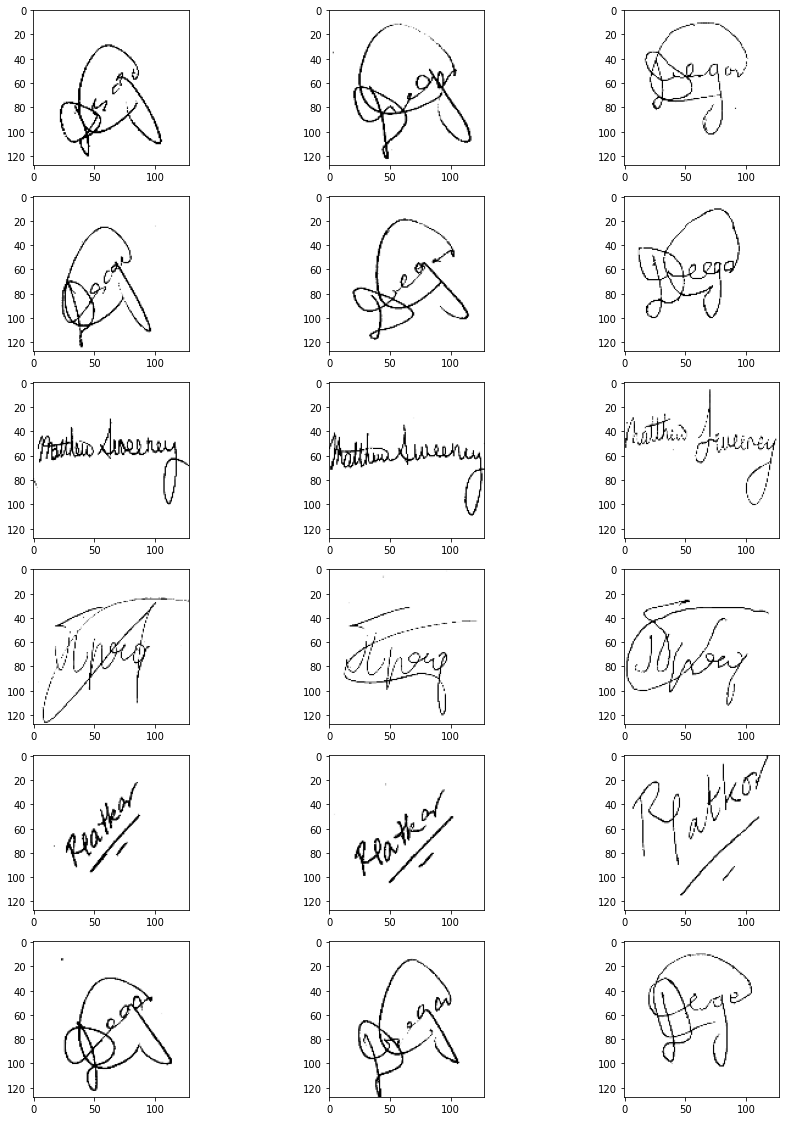

In [27]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        print(a[i].shape)
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [28]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [29]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [30]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

In [31]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [32]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)


In [33]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [34]:
save_all = False
epochs =25
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        type(data)
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 32 sec)
Loss on train    = 0.53755
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.96667

EPOCH: 2 	 (Epoch done in 12 sec)
Loss on train    = 0.04088
1/1 [==============================] - 0s 40ms/step
Accuracy on test = 0.93333

EPOCH: 3 	 (Epoch done in 11 sec)
Loss on train    = 0.00177
1/1 [==============================] - 0s 39ms/step
Accuracy on test = 0.96667

EPOCH: 4 	 (Epoch done in 12 sec)
Loss on train    = 0.00020
1/1 [==============================] - 0s 41ms/step
Accuracy on test = 0.96667

EPOCH: 5 	 (Epoch done in 12 sec)
Loss on train    = 0.00014
1/1 [==============================] - 0s 59ms/step
Accuracy on test = 0.96667

EPOCH: 6 	 (Epoch done in 11 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 46ms/step
Accuracy on test = 0.96667

EPOCH: 7 	 (Epoch done in 11 sec)
Loss on train    = 0.00000
1/1 [==============================] - 0s 44ms/step
Accuracy on test = 0.96667

EPOCH: 8 	 (Ep

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

In [36]:
def classify_images(Signature_list1, Signature_list2, threshold=1.3):
    # Getting the encodings for the passed Signature
    tensor1 = encoder.predict(Signature_list1)
    tensor2 = encoder.predict(Signature_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    #print(distance)
    return prediction

1/1 [==============================] - 0s 96ms/step

Accuracy of model: 0.9705882352941176



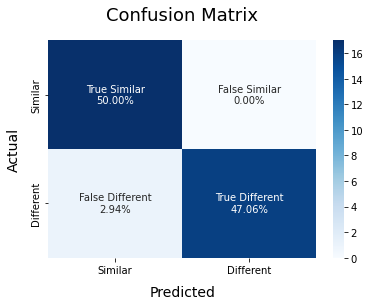

In [37]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=17):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [38]:
Data=prepare_Test_script(Persons["C"],("/content/personC/Test/","personC_32.png"))

In [39]:
Prediction=classify_images(np.asarray([Data[0]]),np.asarray([Data[1]]))

1/1 [==============================] - 0s 18ms/step


In [40]:
print(Prediction[0])

0


  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/anscombe.json (deflated 83%)
  adding: content/sample_data/README.md (deflated 42%)
  adding: content/sample_data/california_housing_train.csv (deflated 79%)
  adding: content/sample_data/mnist_test.csv (deflated 88%)
  adding: content/sample_data/mnist_train_small.csv (deflated 88%)
  adding: content/sample_data/california_housing_test.csv (deflated 76%)
